### as part of this connection, we have to determine if the regulatory overlay affects what water source type per water right site
 - i.e., groundwater regulatory overlay versus surface water overlay
 - will have to read in site.csv and watersource.csv from wr data -> determine watersource type per site -> determine watersource type per regulatory overlay area -> assign reUUID to wr site per matching watersource type

In [10]:
# working with data
import os
import numpy as np
import pandas as pd
import geopandas as gpd # the library that lets us read in shapefiles
import geoplot as gplt # for plotting maps
import geoplot.crs as gcrs #used to pull in webdata

# visulizaiton
import missingno as msno # creates a matrix chart to show missing values
import plotly.express as px
import plotly.graph_objects as go # for subplot creation
from plotly.subplots import make_subplots # for subplot creation
import matplotlib.pyplot as mplt # use with gplt to save fig to pdf

# Cleanup
from datetime import datetime
pd.set_option('display.max_columns', 999)  # How to display all columns of a Pandas DataFrame in Jupyter Notebook

In [11]:
# Working Directory
workingDir = "C:/Users/rjame/Documents/WSWC Documents/MappingStatesDataToWaDE2.0/NewMexico/Regulatory/RawInputData"
os.chdir(workingDir)

In [12]:
# Interstate Stream Compact Regions
inputSF = "Interstate Stream Compact Regions/shapefile/NMInterstateStreamCompactRegions.shp"
gdf = gpd.read_file(inputSF)
print(len(gdf))
gdf.head(1)

8


,States,Source,Compact_Na,URL,Shape__Are,Shape__Len,Full_Name,Shape_Leng,Shape_Area,geometry
0,"CO,NM",NHD HUC10,CCC,http://www.ose.state.nm.us/Compacts/CostillaCr...,0.06555,1.77274,Costilla Creek Compact,1.77274,0.06555,"POLYGON ((-105.50932 36.99594, -105.49790 36.9..."


<GeoAxesSubplot: >

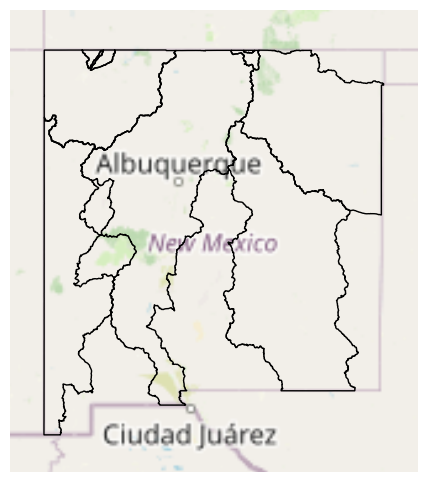

In [16]:
# plot out polygon
contiguous_usa = gpd.read_file(gplt.datasets.get_path('contiguous_usa')) # use for background map in subplot
ax = gplt.webmap(contiguous_usa, projection=gcrs.WebMercator()) # set subplot
gplt.polyplot(gdf, ax=ax)

In [17]:
# NMwr sites.csv
dfs = pd.read_csv('sites.csv')
print(len(dfs))
dfs.head(1)

206468


,SiteUUID,RegulatoryOverlayUUIDs,WaterSourceUUIDs,CoordinateAccuracy,CoordinateMethodCV,County,EPSGCodeCV,Geometry,GNISCodeCV,HUC12,HUC8,Latitude,Longitude,NHDNetworkStatusCV,NHDProductCV,PODorPOUSite,SiteName,SiteNativeID,SitePoint,SiteTypeCV,StateCV,USGSSiteID
0,NMwr_SwadeID1,NaN,NMwr_WSwadeID1,WaDE Unspecified,WaDE Unspecified,NaN,4326,NaN,NaN,NaN,NaN,35.37273,-108.54187,NaN,NaN,POD,WaDE Unspecified,wadeID1,NaN,WaDE Unspecified,NM,NaN


<GeoAxesSubplot: >

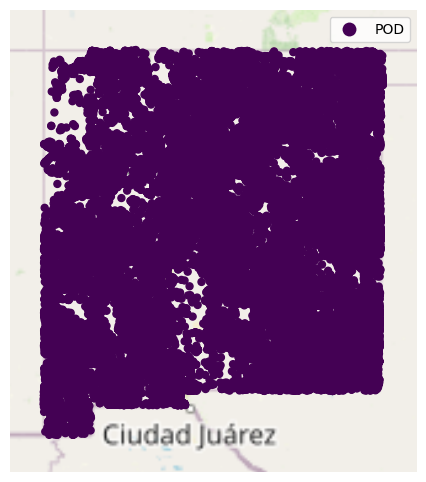

In [18]:
# Map out points
contiguous_usa = gpd.read_file(gplt.datasets.get_path('contiguous_usa')) # use for background map in subplot
ax = gplt.webmap(contiguous_usa, projection=gcrs.WebMercator()) # set subplot
gdfsPoint = gpd.GeoDataFrame(dfs, geometry=gpd.points_from_xy(dfs.Longitude.astype(float), dfs.Latitude.astype(float)), crs="EPSG:4326")
gplt.pointplot(gdfsPoint, hue='PODorPOUSite', legend=True, legend_var='hue', ax=ax)

In [21]:
# try selecting points in polygon, map out new point df.
within_pointsdf = gpd.sjoin(gdfsPoint, gdf, op='within')
print(len(within_pointsdf))
within_pointsdf

C:\Users\rjame\anaconda3\lib\site-packages\IPython\core\interactiveshell.py:3377: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if (await self.run_code(code, result,  async_=asy)):


155226


,SiteUUID,RegulatoryOverlayUUIDs,WaterSourceUUIDs,CoordinateAccuracy,CoordinateMethodCV,County,EPSGCodeCV,Geometry,GNISCodeCV,HUC12,HUC8,Latitude,Longitude,NHDNetworkStatusCV,NHDProductCV,PODorPOUSite,SiteName,SiteNativeID,SitePoint,SiteTypeCV,StateCV,USGSSiteID,geometry,index_right,States,Source,Compact_Na,URL,Shape__Are,Shape__Len,Full_Name,Shape_Leng,Shape_Area
0,NMwr_SwadeID1,NaN,NMwr_WSwadeID1,WaDE Unspecified,WaDE Unspecified,NaN,4326,NaN,NaN,NaN,NaN,35.37273,-108.54187,NaN,NaN,POD,WaDE Unspecified,wadeID1,NaN,WaDE Unspecified,NM,NaN,POINT (-108.54187 35.37273),7,"CO, NM, UT, WY, NV, CA",NHD HUC 6,CORC,http://www.ose.state.nm.us/Compacts/ColoradoRi...,3.35730,17.27692,Colorado River Basin Compact,17.27692,3.35730
136,NMwr_SwadeID100119,NaN,NMwr_WSwadeID2,WaDE Unspecified,WaDE Unspecified,NaN,4326,NaN,NaN,NaN,NaN,34.12359,-108.57955,NaN,NaN,POD,WaDE Unspecified,wadeID100119,NaN,WaDE Unspecified,NM,NaN,POINT (-108.57955 34.12359),7,"CO, NM, UT, WY, NV, CA",NHD HUC 6,CORC,http://www.ose.state.nm.us/Compacts/ColoradoRi...,3.35730,17.27692,Colorado River Basin Compact,17.27692,3.35730
231,NMwr_SwadeID100204,NaN,NMwr_WSwadeID2,WaDE Unspecified,WaDE Unspecified,NaN,4326,NaN,NaN,NaN,NaN,33.03602,-108.70100,NaN,NaN,POD,WaDE Unspecified,wadeID100204,NaN,WaDE Unspecified,NM,NaN,POINT (-108.70100 33.03602),7,"CO, NM, UT, WY, NV, CA",NHD HUC 6,CORC,http://www.ose.state.nm.us/Compacts/ColoradoRi...,3.35730,17.27692,Colorado River Basin Compact,17.27692,3.35730
264,NMwr_SwadeID100234,NaN,NMwr_WSwadeID2,WaDE Unspecified,WaDE Unspecified,NaN,4326,NaN,NaN,NaN,NaN,31.99693,-108.82152,NaN,NaN,POD,WaDE Unspecified,wadeID100234,NaN,WaDE Unspecified,NM,NaN,POINT (-108.82152 31.99693),7,"CO, NM, UT, WY, NV, CA",NHD HUC 6,CORC,http://www.ose.state.nm.us/Compacts/ColoradoRi...,3.35730,17.27692,Colorado River Basin Compact,17.27692,3.35730
270,NMwr_SwadeID10024,NaN,NMwr_WSwadeID2,WaDE Unspecified,WaDE Unspecified,NaN,4326,NaN,NaN,NaN,NaN,31.91999,-108.98612,NaN,NaN,POD,WaDE Unspecified,wadeID10024,NaN,WaDE Unspecified,NM,NaN,POINT (-108.98612 31.91999),7,"CO, NM, UT, WY, NV, CA",NHD HUC 6,CORC,http://www.ose.state.nm.us/Compacts/ColoradoRi...,3.35730,17.27692,Colorado River Basin Compact,17.27692,3.35730
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
205312,NMwr_SwadeID98956,NaN,NMwr_WSwadeID1,WaDE Unspecified,WaDE Unspecified,NaN,4326,NaN,NaN,NaN,NaN,36.76628,-108.49105,NaN,NaN,POD,WaDE Unspecified,wadeID98956,NaN,WaDE Unspecified,NM,NaN,POINT (-108.49105 36.76628),3,"CO, NM, UT, WY",NHD HUC10,UCORC,http://www.ose.state.nm.us/Compacts/UpperColor...,2.43494,10.28904,Upper Colorado River Basin Compact,10.28904,2.43494
205314,NMwr_SwadeID98958,NaN,NMwr_WSwadeID1,WaDE Unspecified,WaDE Unspecified,NaN,4326,NaN,NaN,NaN,NaN,36.67652,-108.07212,NaN,NaN,POD,WaDE Unspecified,wadeID98958,NaN,WaDE Unspecified,NM,NaN,POINT (-108.07212 36.67652),3,"CO, NM, UT, WY",NHD HUC10,UCORC,http://www.ose.state.nm.us/Compacts/UpperColor...,2.43494,10.28904,Upper Colorado River Basin Compact,10.28904,2.43494
205635,NMwr_SwadeID99247,NaN,NMwr_WSwadeID1,WaDE Unspecified,WaDE Unspecified,NaN,4326,NaN,NaN,NaN,NaN,36.52267,-107.54604,NaN,NaN,POD,WaDE Unspecified,wadeID99247,NaN,WaDE Unspecified,NM,NaN,POINT (-107.54604 36.52267),3,"CO, NM, UT, WY",NHD HUC10,UCORC,http://www.ose.state.nm.us/Compacts/UpperColor...,2.43494,10.28904,Upper Colorado River Basin Compact,10.28904,2.43494
205650,NMwr_SwadeID99260,NaN,NMwr_WSwadeID1,WaDE Unspecified,WaDE Unspecified,NaN,4326,NaN,NaN,NaN,NaN,36.19577,-106.97148,NaN,NaN,POD,WaDE Unspecified,wadeID99260,NaN,WaDE Unspecified,NM,NaN,POINT (-106.97148 36.19577),3,"CO, NM, UT, WY",NHD HUC10,UCORC,http://www.ose.state.nm.us/Compacts/UpperColor...,2.43494,10.28904,Upper Colorado River Basin Compact,10.28904,2.43494


<GeoAxesSubplot: >

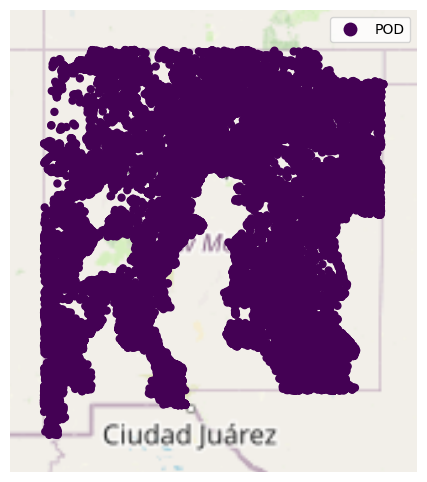

In [20]:
contiguous_usa = gpd.read_file(gplt.datasets.get_path('contiguous_usa')) # use for background map in subplot
ax = gplt.webmap(contiguous_usa, projection=gcrs.WebMercator()) # set subplot
gplt.pointplot(within_pointsdf, hue='PODorPOUSite', legend=True, legend_var='hue', ax=ax)